In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date, timedelta, datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_pinball_loss
from sklearn.linear_model import QuantileRegressor
from matplotlib import pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow_addons.losses import pinball_loss
from sklearn.metrics import mean_pinball_loss
import math
from scipy import stats

In [2]:
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
horizons = [1,2,3,4,5]

# Get data

In [3]:
current_day = datetime.today()
data = yf.download("^GDAXI", start="2000-01-01", end=current_day)["Adj Close"]
data

[*********************100%***********************]  1 of 1 completed


Date
2000-01-03     6750.759766
2000-01-04     6586.950195
2000-01-05     6502.069824
2000-01-06     6474.919922
2000-01-07     6780.959961
                  ...     
2022-01-27    15524.269531
2022-01-28    15318.950195
2022-01-31    15471.200195
2022-02-01    15619.389648
2022-02-02    15639.469727
Name: Adj Close, Length: 5605, dtype: float64

## Data preparation

Add all five horizons as a predictor

In [4]:
data_prep = pd.DataFrame(data)
data_prep["log_return"] = 100 * (np.log(data_prep) - np.log(data_prep.shift(1)))

for horizon in range(1,6):
    data_prep[horizon] = 100 * (np.log(data_prep["Adj Close"]) - np.log(data_prep["Adj Close"].shift(horizon)))
    data_prep[horizon] = data_prep[horizon].shift(-horizon)

#Drop CLose
data_prep.drop("Adj Close", axis = 1, inplace = True)

## Add positional encoding

In [5]:
pos_enc = pd.DataFrame(index = data_prep.index)
#Year encoding
pos_enc["Year"] = pos_enc.index.year
pos_enc["n_days"] = 365
pos_enc.loc[(pos_enc["Year"]-2000)%4 ==0,"n_days"] = 366
pos_enc["Year"] = pos_enc["Year"] - pos_enc["Year"].min()
#Positional encoding
cos_encoding = np.cos(2*math.pi*pos_enc.index.dayofyear/pos_enc["n_days"])
data_prep.insert(1, "cos_enc", cos_encoding)

## Add return of other indices

In [6]:
#Through time difference it is the previous day course
nas = yf.download("^IXIC", start="2000-01-01", end=current_day)["Adj Close"]
nas_ret = np.log(nas) - np.log(nas.shift(1))
data_prep.insert(2, "nasdaq", nas_ret)

[*********************100%***********************]  1 of 1 completed


## Train-Test-split

In [7]:
def normalize(data, mean, sd):
    return (data - mean)/sd

In [8]:
def sliding_window(data,window_size):
    window = sliding_window_view(data.to_numpy(), window_size, axis = 0)
    window = np.swapaxes(window, 1,2)
    return window

In [9]:
def convert_data(data):
    features = data[:,:,0:3]
    X = features
    Y = np.expand_dims(data[:,-1,3:],2)
    return X,Y

In [10]:
#Define parameters
window_size = 128
test_split = 0.2
#Set seed
np.random.seed(1)
#Choose years
years = data.index.year.unique()[:-1]
n_years = int(np.floor(test_split*len(years)))
test_years = np.sort(np.random.choice(years,n_years))

# Get prediction data
pred_data = data_prep[-window_size:]

#Drop Nans
data_prep.dropna(inplace = True)

In [11]:
#Get train mean and sd
train_prep = data_prep[~data_prep.index.year.isin(test_years)]
train_mean = train_prep.mean()
train_sd = train_prep.std()

#Normalize
data_prep = normalize(data_prep, train_mean, train_sd)

In [12]:
#Add beginning and end year to make enumerating easier
index = np.insert(test_years, 0, 2000)
index = np.insert(index, len(index), 2023)

#Create arrays
train_data = np.zeros(shape = (1,window_size,8))
test_data = np.zeros(shape = (1,window_size,8))

for i in range(len(index)-1):

    #Extract start and and year of train data
    start_train = index[i]
    end_train = index[i+1]
    #Extract start and end date of test data (overlapping)
    start_test = date(year = end_train, month = 1, day = 1) - timedelta(int(np.floor(window_size*7/5)))
    end_test = date(year = end_train, month = 12, day = 31)

    #Training data
    data_train = data_prep[(data_prep.index.year >= start_train) & (data_prep.index.year < end_train)]
    train_data = np.append(train_data, sliding_window(data_train, window_size), axis = 0)
    
    #Test data
    if (i+1) != len(index)-1:
        data_test = data_prep.loc[start_test:end_test]
        test_data = np.append(test_data, sliding_window(data_test, window_size), axis = 0)

#Remove first row from data
train_data = np.delete(train_data, 0, axis = 0)
test_data = np.delete(test_data, 0, axis = 0)

In [13]:
x_train, y_train = convert_data(train_data)
x_test, y_test = convert_data(test_data)

## Build model

In [14]:
def model(dropout_rate = 0.1, window_size = window_size):
    
    #Define parameters
    filters = 16
    kernel_size = 2
    dilation_rates = [2**i for i in range(7)]
    
    #Define Inputs
    input_features = Input(shape=(window_size, 3))

    x = input_features
    #Base layers
    skips = []
    for dilation in dilation_rates:
        #Preprocessing layer
        x = Conv1D(16, 1, padding='same', activation='relu')(x) 
        #Dilated convolution
        z = Conv1D(filters, kernel_size, activation="relu", padding="causal", dilation_rate=dilation)(x)
        #Postprocessing
        z = Conv1D(16, 1, padding='same', activation='relu')(z)
        #Residual connection
        x = Add()([x,z])

    #Fully Connected Layer
    out = Conv1D(32, 1, padding = "same")(x)
    out = Dropout(dropout_rate)(out)
    out = Conv1D(1, 1, activation="linear")(out)
    out = Flatten()(out)
    out = Dense(5)(out)
    cnn = Model(input_features, out)
    return cnn

In [ ]:
cnn = model()
cnn.summary()

In [ ]:
BATCH_SIZE = 128
EPOCHS = 100
val_split = 0.2
learning_rate = 0.05
optimizer = tf.keras.optimizers.Adadelta(learning_rate = learning_rate)

#Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 4, min_delta = 1e-5)

In [ ]:
def train_model(model, optimizer, x_train, y_train, quantile, val_split = val_split, BATCH_SIZE = BATCH_SIZE, EPOCHS = EPOCHS, callback = callback, verbose = False):
    model.compile(optimizer = optimizer,  loss = lambda true,pred: pinball_loss(true, pred, tau = quantile))
    history = model.fit(x_train, y_train, validation_split = val_split, epochs = EPOCHS, batch_size = BATCH_SIZE, shuffle=True,
        callbacks = [callback], verbose = verbose)
    return model

In [ ]:
def train_all_models(x_train, y_train, val_split = val_split, quantiles = quantiles, optimizer = optimizer, batch_size = BATCH_SIZE, epochs = EPOCHS, callback = callback):
    models = dict()
    for quantile in quantiles:
        cnn = model()
        cnn = train_model(cnn, optimizer, x_train, y_train, quantile)
        print("Training finished for quantile {}".format(quantile))
        models[quantile] = cnn
    return models

In [ ]:
models = train_all_models(x_train, y_train)

## Predict test data

In [20]:
predictions = dict()
for quantile in quantiles:
    pred = models[quantile].predict(x_test)
    predictions[quantile]=pred

### Evaluate Loss

In [21]:
true_values = np.squeeze(y_test)
total_loss = 0
for quantile in quantiles:
    pred = np.squeeze(predictions[quantile])
    loss = mean_pinball_loss(true_values, pred, alpha = quantile)
    total_loss += loss
    print("Pinball Loss for quantile {}: \t {}".format(quantile, loss))
print("Pinball Loss total: {}".format(total_loss/len(quantiles)))

Pinball Loss for quantile 0.025: 	 0.09445844012036361
Pinball Loss for quantile 0.25: 	 0.350157926887103
Pinball Loss for quantile 0.5: 	 0.3963248330093575
Pinball Loss for quantile 0.75: 	 0.3120612569003443
Pinball Loss for quantile 0.975: 	 0.07413882709863892
Pinball Loss total: 0.24542825680316147


### Test plausability

In [22]:
true_values = np.squeeze(y_test)
for quantile in quantiles:
    pred = np.squeeze(predictions[quantile])
    q_smaller = (pred >= true_values).sum()
    emp_quant = q_smaller / true_values.size
    print("Quantile met for quantile = {}: \t {} %".format(quantile, np.round(emp_quant,4)*100))

Quantile met for quantile = 0.025: 	 4.0 %
Quantile met for quantile = 0.25: 	 25.82 %
Quantile met for quantile = 0.5: 	 49.18 %
Quantile met for quantile = 0.75: 	 75.41 %
Quantile met for quantile = 0.975: 	 97.0 %


### Plot predictions

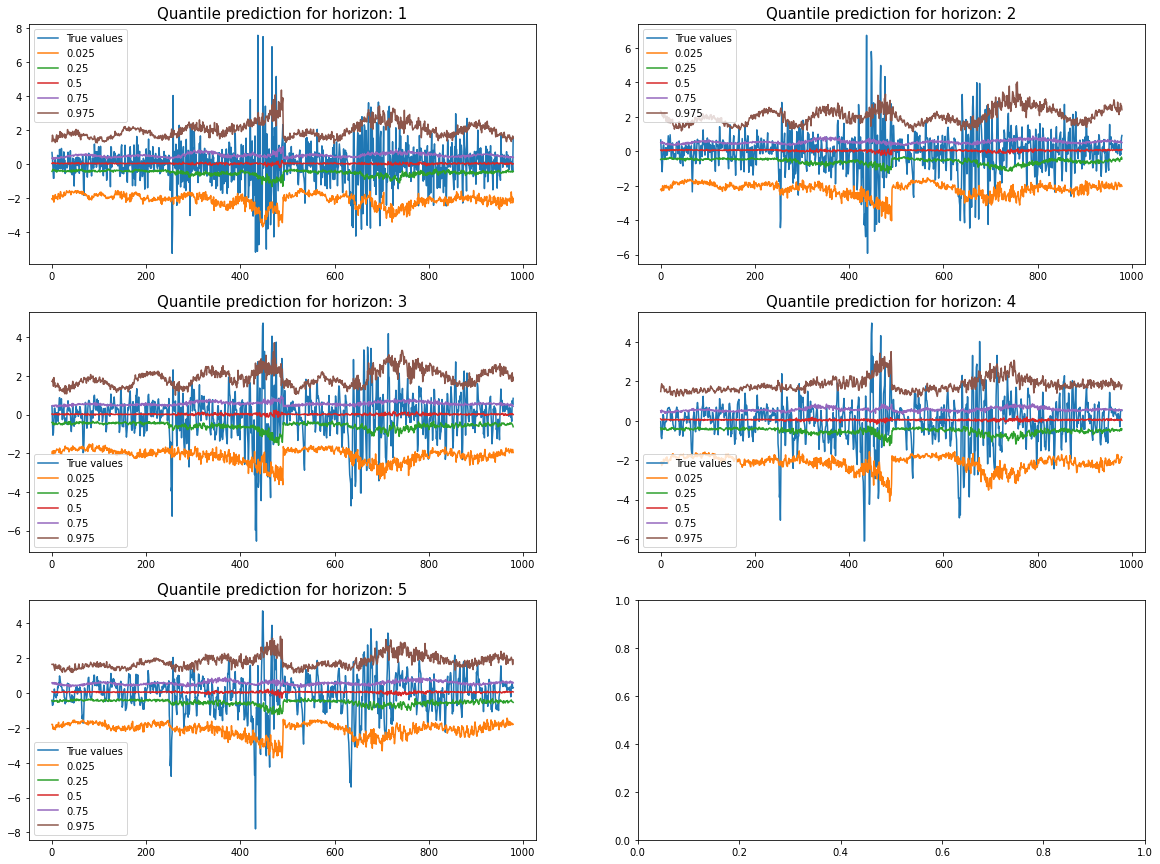

In [23]:
fig, axs = plt.subplots(3,2,figsize = (20,15))
axs = axs.ravel()
length = len(test_data)-window_size+1

for cnt,horizon in enumerate(horizons):

    sns.lineplot(x = np.arange(len(true_values)), y = true_values[:,cnt], ax = axs[cnt])
    for quantile in quantiles:
        sns.lineplot(x = np.arange(len(true_values)), y = predictions[quantile][:,cnt], ax = axs[cnt])
    axs[cnt].set_title("Quantile prediction for horizon: {}".format(horizon), size = 15)
    labels = ["True values",0.025, 0.25, 0.5, 0.75, 0.975]
    axs[cnt].legend(labels)

## Predict new data

In [24]:
x_train, y_train = convert_data(np.append(train_data,test_data,axis = 0))
#Normalize
pred_data = normalize(pred_data, train_mean, train_sd)
pred_data = sliding_window(pred_data,window_size)
x_pred, y_pred = convert_data(pred_data)

In [25]:
models = train_all_models(x_train, y_train)

Training finished for quantile 0.025
Training finished for quantile 0.25
Training finished for quantile 0.5
Training finished for quantile 0.75
Training finished for quantile 0.975


In [26]:
predictions = dict()
for quantile in quantiles:
    pred = models[quantile].predict(x_pred)
    predictions[quantile]=pred

In [27]:
future_pred = np.zeros(shape = (5,5))
for cnt,quantile in enumerate(quantiles):
    future_pred[cnt] = models[quantile].predict(x_pred)
#Renormalize
for h in range(5):
    future_pred[:,h] = future_pred[:,h]*train_sd[h+1] + train_mean[h+1]

In [28]:
df_horizons = [1,2,5,6,7]
final_prediction = pd.DataFrame(columns = ["forecast_date","target","horizon","q0.025","q0.25","q0.5","q0.75","q0.975"])
final_prediction["forecast_date"] = [(current_day).strftime("%Y-%m-%d") for x in df_horizons]
final_prediction["horizon"] = ["{} day".format(x) for x in df_horizons]
final_prediction["target"] = "DAX"

for cnt, quantile in enumerate(quantiles):
    final_prediction["q{}".format(quantile)] = future_pred[cnt,:]

In [29]:
final_prediction

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2022-02-02,DAX,1 day,-2.949804,-0.618588,0.091216,0.627301,3.113593
1,2022-02-02,DAX,2 day,-3.930682,-0.570820,0.132000,1.117254,3.857940
2,2022-02-02,DAX,5 day,-4.572057,-0.875615,0.223882,1.350499,5.045979
3,2022-02-02,DAX,6 day,-4.632564,-1.111586,0.183490,1.686815,5.085512
4,2022-02-02,DAX,7 day,-6.009076,-1.235225,0.426151,1.968779,4.968291


## Save final prediction

In [30]:
current_date = date.today().strftime("%Y-%m-%d")
final_prediction.to_pickle("../evaluation/predictions/single/DAX_{}".format(current_date))